In [1]:
import matplotlib
from matplotlib_venn import venn3
from matplotlib import pyplot as plt
import statistics

In [2]:
# input files
gfffile = '../../../figshare/annotation/genes/Elysia_crispata_ECLA1_v1.gff'
annfile = '../../../figshare/functional_enrichment_analysis/Elysia_eggnog_annotations.txt'
tpmfile = '../../../figshare/gene_expression/lengthScaledTPM.matrix'
ogfile = '../../../figshare/orthofinder/Orthogroups/Orthogroups.tsv'

highqualityfile = '../../../figshare/annotation/genes/Elysia_crispata_ECLA1_high_quality_geneset.txt'

In [5]:
# Read GFF for gene and exon counts/lengths
geneDict = {}
exonDict = {}

fi = open(gfffile)

for line in fi:
    col = line.rstrip().split('\t')
    ftype = col[2]
    start = int(col[3])
    end = int(col[4])
    
    if ftype == 'gene':
        glen = end - start
        gid = col[8].split('ID=')[1].split(';')[0]
        #print(gid,glen)
        
        geneDict[gid] = glen
        
    if ftype == 'exon':
        elen = end - start
        eid = col[8].split('ID=')[1].split(';')[0]
        tid = col[8].split('Parent=')[1].split(';')[0]
        gid = tid.split('.')[0]
        #print(eid, tid, elen)
        
        if tid not in exonDict:
            exonDict[tid] = {}
        
        exonDict[tid][eid] = elen

fi.close()

# Summary statistics for Total Gene Set
## Number of genes

In [6]:
len(geneDict)

68514

## Mean and Median gene length

In [7]:
sum(geneDict.values()) / len(geneDict.values())

5779.5676212161015

In [8]:
statistics.median(geneDict.values())

2483.0

## Number of transcripts/proteins

In [9]:
len(exonDict)

71367

In [10]:
ecountList = []
elenList = []

for tid in exonDict:
    ecount = len(exonDict[tid])
    ecountList.append(ecount)
    
    for eid in exonDict[tid]:
        elenList.append(exonDict[tid][eid])

## Mean and median number of expon per transcript/protein

In [11]:
sum(ecountList) / len(ecountList)

4.8210937828408085

In [12]:
statistics.median(ecountList)

3

## Mean and median exon length

In [13]:
sum(elenList) / len(elenList)

207.2859297753054

In [14]:
statistics.median(elenList)

132

In [60]:
# Read annotation file
annotatedSet = set()
anndbDict = {}
anndbDict['GO'] = set()
anndbDict['KEGG'] = set()
anndbDict['PFAM'] = set()
anndbDict['CAZY'] = set()

fi = open(annfile)

for line in fi:
    if line[0] == '#':
        continue
    
    col = line.rstrip().split('\t')
    
    gene = col[0].split('.')[0]
    annotatedSet.add(gene)
    
    gos = col[9]
    if gos != '-':
        #print(gos.split(',')[0])
        anndbDict['GO'].add(gene)
        
    keggs = col[11]
    if keggs != '-':
        #print(keggs.split(',')[0])
        anndbDict['KEGG'].add(gene)
        
    cazys = col[18]
    if cazys != '-':
        #print(cazys.split(',')[0])
        anndbDict['CAZY'].add(gene)

    pfams = col[20]
    if pfams != '-':
        #print(pfams.split(',')[0])
        anndbDict['PFAM'].add(gene)    

fi.close()

In [63]:
for cat in anndbDict:
    print(cat, len(anndbDict[cat]), len(anndbDict[cat])/len(geneDict.values())*100)

GO 10287 15.01444960154129
KEGG 10624 15.506319876229677
PFAM 16601 24.23008436232011
CAZY 341 0.4977084975333508


## Number of genes with annotation support

In [18]:
len(annotatedSet)

17963

## Percentage of genes with annotation support

In [19]:
len(annotatedSet) / len(geneDict) * 100

26.21799924103103

In [21]:
# Read orthogroup file
orthogroupedSet = set()

fi = open(ogfile)

for line in fi:
    col = line.rstrip().split('\t')
    
    if col[0] == 'Orthogroup':
        continue
        
    og = col.pop(0)
    if len(col) < 3:
        continue 
        
    genes = col.pop(2)
    if genes == '':
        continue
    genelist = genes.split(', ')
    
    count = 0
    for sp in col:
        if sp != '':
            count += 1
    
    #print(og, count)
    if count > 0:
        for gene in genelist:
            gene = gene.split('.')[0]
            #print(og,gene)
            orthogroupedSet.add(gene)

fi.close()

## Number of genes with orthogroup support

In [22]:
len(orthogroupedSet)

28489

## Percentage of genes with orthogroup support

In [23]:
len(orthogroupedSet) / len(geneDict) * 100

41.581282657559036

In [25]:
# Read TPM expression file
expressed1Set = set()
expressed2Set = set()
expressed10Set = set()

fi = open(tpmfile)

for line in fi:
    col = line.rstrip().split('\t')
    if col[0] == 'AS1':
        continue
    
    gene = col.pop(0)
    
    col = [float(i) for i in col]
    
    #print(gene)
    
    jslug = sum(col[0:3]) / 3
    egg = sum(col[6:9]) /3
    vel = sum(col[12:]) / 3
    lslug = sum(col[9:12]) / 3
    #print(gene,lslug)
    
    avgtmp = [egg, vel, lslug, jslug]
    #print(gene, max(avgtmp))
    
    if max(avgtmp) > 1:
        expressed1Set.add(gene)
        
    if max(avgtmp) >= 2:
        expressed2Set.add(gene)

    if max(avgtmp) >= 10:
        expressed10Set.add(gene)    

fi.close()

## Number of genes with expression support

In [26]:
len(expressed1Set)

45593

## Percentage of genes with expression support

In [28]:
len(expressed1Set) / len(geneDict) * 100

66.54552354263362

# Plot support overlap (TPM >=1)

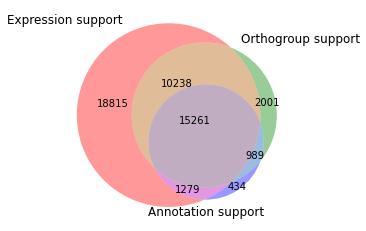

In [29]:
venn3([expressed1Set, orthogroupedSet, annotatedSet], ('Expression support', 'Orthogroup support', 'Annotation support'))
matplotlib.pyplot.savefig('figures/annotation_support_venn_diagram.pdf')

plt.show()

In [30]:
sum([10238,15261,1279,989])

27767

## Number of genes with two or more types of support

In [31]:
len(expressed1Set.intersection(orthogroupedSet).union(annotatedSet.intersection(orthogroupedSet)).union(annotatedSet.intersection(expressed1Set)))

27767

# Plot support overlap (TPM >=2)

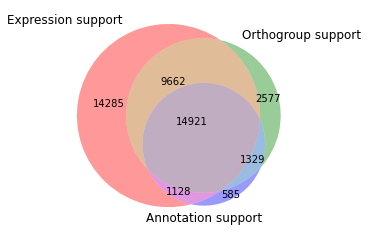

In [32]:
venn3([expressed2Set, orthogroupedSet, annotatedSet], ('Expression support', 'Orthogroup support', 'Annotation support'))
plt.show()

## Number of genes with two or more types of support

In [33]:
len(expressed2Set.intersection(orthogroupedSet).union(annotatedSet.intersection(orthogroupedSet)).union(annotatedSet.intersection(expressed2Set)))

27040

# Plot support overlap (TPM >= 10)

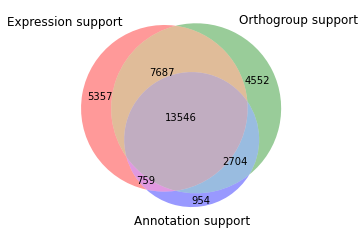

In [34]:
venn3([expressed10Set, orthogroupedSet, annotatedSet], ('Expression support', 'Orthogroup support', 'Annotation support'))
plt.show()

## Number of genes with two or more types of support

In [35]:
len(expressed10Set.intersection(orthogroupedSet).union(annotatedSet.intersection(orthogroupedSet)).union(annotatedSet.intersection(expressed10Set)))

24696

# Summary Statistics for High Quality gene set
Using relaxed TPM >= 1 threshold

In [36]:
hqgeneSet = expressed1Set.intersection(orthogroupedSet).union(annotatedSet.intersection(orthogroupedSet)).union(annotatedSet.intersection(expressed1Set))

In [37]:
fo = open(highqualityfile, 'w')

for gene in hqgeneSet:
    #print(gene)
    fo.write(gene + '\n')

fo.close()

## Number of genes

In [38]:
len(hqgeneSet)

27767

## Mean and Median gene length

In [39]:
hqgeneDict = {}

for gene in geneDict:
    if gene in hqgeneSet:
        hqgeneDict[gene] = geneDict[gene]
        
sum(hqgeneDict.values()) / len(hqgeneDict.values())

10610.161954838477

In [40]:
statistics.median(hqgeneDict.values())

6891

## Number of transcripts/proteins

In [41]:
hqexonDict = {}

for tid in exonDict:
    gene = tid.split('.')[0]
    if gene in hqgeneSet:
        hqexonDict[tid] = exonDict[tid]
    
len(hqexonDict)

30043

In [42]:
hqecountList = []
hqelenList = []

for tid in hqexonDict:
    ecount = len(hqexonDict[tid])
    hqecountList.append(ecount)
    
    for eid in hqexonDict[tid]:
        hqelenList.append(hqexonDict[tid][eid])

## Mean and Median number of expons per transcript/protein

In [43]:
sum(hqecountList) / len(hqecountList)

8.110175415238158

In [44]:
statistics.median(hqecountList)

5

## Mean and Median exon length

In [45]:
sum(hqelenList) / len(hqelenList)

201.20460160719708

In [46]:
statistics.median(hqelenList)

128.0

## Number of genes with annotation support

In [47]:
len(annotatedSet.intersection(hqgeneSet)) 

17529

## Percentage of genes with annotation support

In [48]:
len(annotatedSet.intersection(hqgeneSet)) / len(hqgeneSet) * 100

63.12889401087622

In [67]:
#GO
print('GO', len(anndbDict['GO'].intersection(hqgeneSet)), len(anndbDict['GO'].intersection(hqgeneSet))/len(hqgeneSet)*100)    

GO 10191 36.70184031404185


In [68]:
#GO
print('KEGG', len(anndbDict['KEGG'].intersection(hqgeneSet)), len(anndbDict['KEGG'].intersection(hqgeneSet))/len(hqgeneSet)*100)    


KEGG 10498 37.80746929808766


In [69]:
##CAZY
print('CAZY', len(anndbDict['CAZY'].intersection(hqgeneSet)), len(anndbDict['CAZY'].intersection(hqgeneSet))/len(hqgeneSet)*100)    


CAZY 337 1.2136709043108727


In [70]:
##PFAM
print('PFAM', len(anndbDict['PFAM'].intersection(hqgeneSet)), len(anndbDict['PFAM'].intersection(hqgeneSet))/len(hqgeneSet)*100)    



PFAM 16220 58.41466488997731


## Number of genes with orthogroup support

In [49]:
len(orthogroupedSet.intersection(hqgeneSet)) 

26488

## Percentage of genes with orthogroup support

In [50]:
len(orthogroupedSet.intersection(hqgeneSet)) / len(hqgeneSet) * 100

95.39381279936615

## Number of genes with expression support

In [51]:
len(expressed1Set.intersection(hqgeneSet)) 

26778

## Percentage of genes with expression support

In [52]:
len(expressed1Set.intersection(hqgeneSet)) / len(hqgeneSet) * 100

96.43821802859509